# Axisymmetric Spacetimes : Kerr in Kerr-Schild

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from numpy.polynomial.legendre import leggauss

## Importing & Accessing data 

In [190]:
df = pd.read_csv("data.csv")
print(df)

theta = df["theta"].values
h = df["h"].values

            theta         h
0    1.000000e-08  1.937816
1    6.295787e-03  1.937816
2    1.259156e-02  1.937818
3    1.888734e-02  1.937821
4    2.518312e-02  1.937826
..            ...       ...
495  3.116410e+00  1.937826
496  3.122705e+00  1.937821
497  3.129001e+00  1.937818
498  3.135297e+00  1.937816
499  3.141593e+00  1.937816

[500 rows x 2 columns]


## Values of your own control!

In [191]:
# Modify the value here (from input.py):
Ntheta = 500
M = 1.0
a = 0.5

# Modify with your own phi resolution! 
phi = np.linspace(0, 2*np.pi, Ntheta)

# Making a meshgrid of theta and phi values
phi_grid, theta_grid = np.meshgrid(phi, theta)

## Initial guess function $h(\theta)_{\text{guess}}$, from Input.py

### See here -> https://www.desmos.com/calculator/x6iyq0kvln

In [192]:
def hguess(theta):
    eps = 0.05
    R0 = M + np.sqrt(M**2 - a**2)
    P2 = 0.5*(3*np.cos(theta)**2 - 1)
    return R0*(1 + eps*P2)

h0 = hguess(theta)
#print(h0)

## Conversion to Cartesian coordinates for 3D visualisations

In [193]:
def cartesian(r, t, p):
    x = np.sqrt(r**2 + a**2)*np.sin(t)*np.cos(p)
    y = np.sqrt(r**2 + a**2)*np.sin(t)*np.sin(p)
    z = r*np.cos(t)
    return x, y, z

In [194]:
# Make h0 and h 2D arrays matching theta_grid
h0_2d = np.tile(h0[:, np.newaxis], (1, phi_grid.shape[1]))
h_2d = np.tile(h[:, np.newaxis], (1, phi_grid.shape[1]))

# Converting to Cartesian 
x0, y0, z0 = cartesian(h0_2d, theta_grid, phi_grid)
xsol, ysol, zsol= cartesian(h_2d, theta_grid, phi_grid)

## Plotting! 

### 2D Visualisation

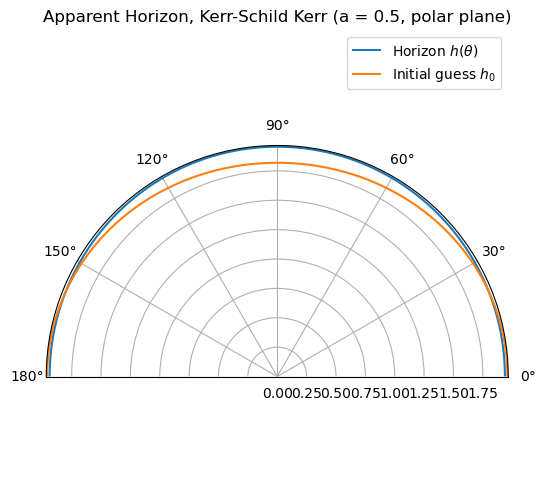

In [195]:
fig2D_polar = plt.figure(figsize=(15, 6))
ax = fig2D_polar.add_subplot(111, polar=True)

ax.set_thetamin(0)
ax.set_thetamax(180)
ax.plot(theta, h, label=r"Horizon $h(\theta)$")
ax.plot(theta, h0, label=r"Initial guess $h_0$")
ax.set_title(f"Apparent Horizon, Kerr-Schild Kerr (a = {a}, polar plane)")
ax.legend()

plt.savefig("./Plots/AHpolarKerr.png", dpi=300, bbox_inches="tight")
plt.show()

### 3D Visualisation

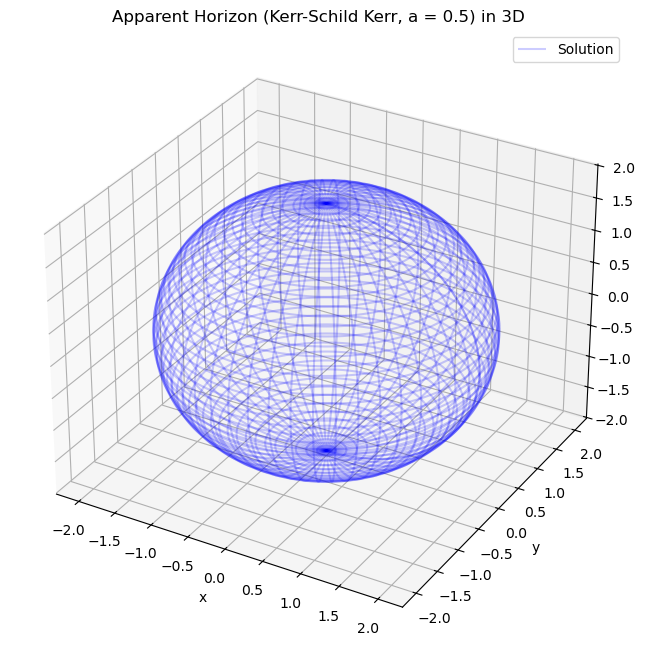

In [196]:
fig3D = plt.figure(figsize=(10,8))
ax = fig3D.add_subplot(111, projection='3d')

#ax.scatter(x0, y0, z0, c="orange", label="Initial guess", s=10)
#ax.scatter(xsol, ysol, zsol, c="blue", label="Solution", s=10)
#ax.plot_wireframe(x0, y0, z0, color="red", alpha=0.5, label="Initial guess")
ax.plot_wireframe(xsol, ysol, zsol, color="blue", alpha=0.2, label="Solution")

#ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title(f"Apparent Horizon (Kerr-Schild Kerr, a = {a}) in 3D")
ax.legend()

plt.savefig("./Plots/AH3DKerr.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross section of 3D plot above

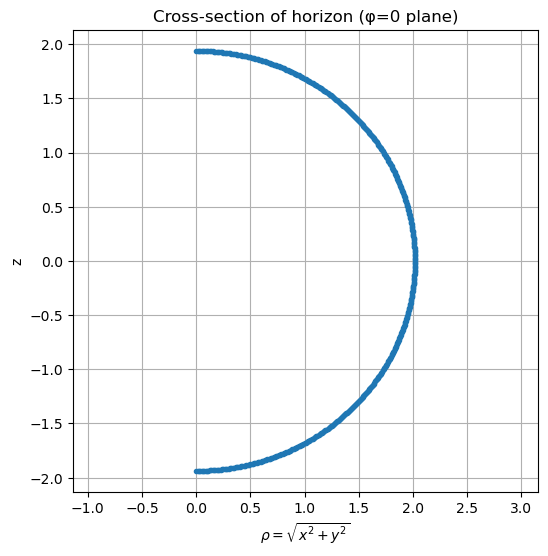

In [197]:
i_phi = 0  # slice at phi = 0 plane
x_slice = xsol[:, i_phi]
y_slice = ysol[:, i_phi]
z_slice = zsol[:, i_phi]

rho_slice = np.sqrt(x_slice**2 + y_slice**2)

plt.figure(figsize=(6,6))
plt.plot(rho_slice, z_slice, '-o', markersize=3)
plt.xlabel(r'$\rho = \sqrt{x^2 + y^2}$')
plt.ylabel('z')
plt.title('Cross-section of horizon (φ=0 plane)')
plt.axis('equal')
plt.grid(True)
plt.show()

## Area calculation!

### Spatial Metric $\gamma_{ij}$

In [198]:
def lvec(r, theta, phi, a):
    """l^i vector in Kerr-Schild Cartesian coordinates"""
    R = r**2 + a**2
    x = np.sqrt(R)*np.sin(theta)*np.cos(phi)
    y = np.sqrt(R)*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    lx = (r*x + a*y)/R
    ly = (r*y - a*x)/R
    lz = z/r
    return lx, ly, lz

def H_func(theta, r, M, a):
    """Kerr-Schild H function"""
    return M * r / (r**2 + a**2 * np.cos(theta)**2)

def gammac(r, theta, phi, M, a):
    """Spatial 3-metric in Cartesian Kerr-Schild coordinates"""
    lx, ly, lz = lvec(r, theta, phi, a)
    H = H_func(theta, r, M, a)
    gamma = np.zeros((3,3))
    gamma[0,0] = 1 + 2*H*lx**2
    gamma[0,1] = 2*H*lx*ly
    gamma[1,0] = gamma[0,1]
    gamma[0,2] = 2*H*lx*lz
    gamma[2,0] = gamma[0,2]
    gamma[1,1] = 1 + 2*H*ly**2
    gamma[1,2] = 2*H*ly*lz
    gamma[2,1] = gamma[1,2]
    gamma[2,2] = 1 + 2*H*lz**2
    return gamma

def jacobian(r, theta, phi, a):
    """Jacobian from spheroidal (r,theta,phi) to Cartesian (x,y,z)"""
    R = r**2 + a**2
    J = np.zeros((3,3))
    J[0,0] = r*np.sin(theta)*np.cos(phi)/np.sqrt(R)
    J[0,1] = np.sqrt(R)*np.cos(theta)*np.cos(phi)
    J[0,2] = -np.sqrt(R)*np.sin(theta)*np.sin(phi)
    J[1,0] = r*np.sin(theta)*np.sin(phi)/np.sqrt(R)
    J[1,1] = np.sqrt(R)*np.cos(theta)*np.sin(phi)
    J[1,2] = np.sqrt(R)*np.sin(theta)*np.cos(phi)
    J[2,0] = np.cos(theta)
    J[2,1] = -r*np.sin(theta)
    J[2,2] = 0
    return J

def gammaij(r, theta, phi, M, a):
    """Spatial metric in spheroidal coordinates"""
    gamma_cart = gammac(r, theta, phi, M, a)
    J = jacobian(r, theta, phi, a)
    gamma_sph = J.T @ gamma_cart @ J
    return gamma_sph

### Computing $\frac{dh}{d\theta}$

In [199]:
dhdtheta = np.gradient(h, theta)

### Compute area integral (axisymmetric)

In [203]:
# 1. Smooth interpolation of h(theta)
h_spline = CubicSpline(theta, h)
dh_spline = h_spline(theta, 1)  # first derivative at original points

# 2. Gauss-Legendre quadrature over theta
N_gl = 200
x_gl, w_gl = leggauss(N_gl)
theta_gl = 0.5*(x_gl + 1)*np.pi          # map [-1,1] -> [0, pi]
w_theta = 0.5*np.pi * w_gl               # adjust weights
h_gl = h_spline(theta_gl)
dh_gl = h_spline(theta_gl, 1)

# 3. Area integration
area_integrand = np.zeros_like(theta_gl)

phi = 0.0  # axisymmetry
for i, (th, r_val, dh) in enumerate(zip(theta_gl, h_gl, dh_gl)):
    g = gammaij(r_val, th, phi, a, M)  # your gammaij function
    gamma_rr = g[0,0]
    gamma_thth = g[1,1]
    gamma_phph = g[2,2]
    gamma_rth = g[0,1]
    gamma_rph = g[0,2]
    gamma_thph = g[1,2]

    det_term = (gamma_rr*dh**2 + 2*gamma_rth*dh + gamma_thth) * gamma_phph
    det_term -= (gamma_rr*dh*0 + gamma_rph*dh + gamma_rth*0 + gamma_thph)**2
    area_integrand[i] = np.sqrt(det_term)

# Multiply by Gauss-Legendre weights and 2pi for phi
area = 2*np.pi * np.sum(area_integrand * w_theta)

# 4. Analytical Kerr area
r_plus = M + np.sqrt(M**2 - a**2)
A_analytic = 4*np.pi*(r_plus**2 + a**2)

print("Numerical horizon area:", area)
print("Analytical Kerr horizon area:", A_analytic)

Numerical horizon area: 57.779966046811786
Analytical Kerr horizon area: 46.898333599528954
